# Problem Description

This problem uses the HEPMASS dataset to compare the performance of three different boosting models: `GradientBoostingClassifier` from scikit-learn, `XGB` from XGBoost, and `LGB` from LightGBM. With the two later model, we use threshold 0.5 to classify the predictions. The goal is to classify particle-producing collisions from background sources in high-energy physics experiments using 27 normalized features.

The HEPMASS dataset is a binary classification problem where:
- **Signal (class 1)**: Particle-producing collisions with mass=1000
- **Background (class 0)**: Background process collisions
- **Features**: 27 normalized features (22 low-level + 5 high-level features)
- **Dataset**: 50% signal, 50% background (balanced dataset)

The dataset contains:
- Dataset: 3.5 million examples (both training and test sets combined)
- Features: 27 normalized features without missing values
- Target: Binary classification (1 for signal, 0 for background)

> **Note:** To run this code, you need to install the libraries `pandas`, `numpy`, `scikit-learn`, `xgboost`, and `lightgbm`. You can install them via pip if you don't have them:
> ```bash
> pip install pandas numpy scikit-learn xgboost lightgbm shap
> ```

> **Hypothesis:** Given that this is a large dataset, we expect LightGBM to be the fastest, followed by XGBoost, and finally GradientBoostingClassifier from scikit-learn. For accuracy, we expect all three models to perform similarly well, but XGBoost and LightGBM might have a slight edge due to their advanced optimization techniques.

# Import Library

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
import os

# Load HEPMASS dataset
train_path = './particles.csv'

# Load the data
print("Loading HEPMASS dataset...")
train = pd.read_csv(train_path)
print(f"Loaded {len(train):,} rows of data")

# The first column is the class label, followed by 27 features
print(f"Dataset shape: {train.shape}")
print(f"Number of features: {train.shape[1] - 1}")

print(f"\nFirst 5 rows:")
print(train.head())

Loading HEPMASS dataset...
Loaded 3,500,000 rows of data
Dataset shape: (3500000, 28)
Number of features: 27

First 5 rows:
   # label        f0        f1        f2        f3        f4        f5  \
0      0.0  0.094394  0.012756  0.911933 -0.090831 -0.233575 -1.054221   
1      1.0  0.979433  0.582031  1.425125  1.149996 -1.619561 -0.005984   
2      1.0  1.076495  0.965307  1.016853  1.187370  0.787062  0.850488   
3      0.0 -1.186220  0.443335  0.003997  0.484752 -1.159905 -1.054221   
4      1.0  1.124759 -1.123493 -1.104635  1.144637 -0.903607 -0.005984   

         f6        f7        f8  ...       f17       f18       f19       f20  \
0 -0.975937 -1.067278 -0.613850  ... -0.815440 -1.376865  0.067591  1.372576   
1  0.815265 -1.175631  0.094345  ...  1.226331 -0.192464  0.009078  0.605600   
2  0.562133  0.446859 -1.129008  ...  1.226331 -0.018303 -0.007021  0.710188   
3 -1.581964 -0.391629  0.529644  ...  1.226331 -0.520804 -1.241476 -0.137923   
4  0.602021 -0.321545  0.838113

# Data Preprocessing and Quality Check

In [3]:
train_clean = train.copy()
print(f"Original data: {len(train_clean):,} rows")

# Separate features and target
# First column is the class label (target)
y = train_clean.iloc[:, 0].copy()
X = train_clean.iloc[:, 1:].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:")
print(y.value_counts().sort_index())

Original data: 3,500,000 rows

Features shape: (3500000, 27)
Target shape: (3500000,)
Target distribution:
# label
0.0    1750755
1.0    1749245
Name: count, dtype: int64


# Feature Analysis and Statistics

In [4]:
print("Analyzing features...")

# Create proper column names for the features
feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]
X.columns = feature_names

print(f"Total features: {len(feature_names)}")
print(f"Features: {feature_names[:10]}...")  # Show first 10 feature names

# Check feature correlations with target
correlations = []
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    correlations.append((col, abs(corr)))

# Sort by absolute correlation
correlations.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 10 features most correlated with target:")
for i, (feature, corr) in enumerate(correlations[:10]):
    print(f"{i+1:2d}. {feature}: {corr:.4f}")

Analyzing features...
Total features: 27
Features: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']...

Top 10 features most correlated with target:
 1. feature_7: 0.7658
 2. feature_27: 0.7014
 3. feature_11: 0.6428
 4. feature_15: 0.5143
 5. feature_4: 0.4170
 6. feature_26: 0.4041
 7. feature_1: 0.3735
 8. feature_19: 0.3659
 9. feature_24: 0.2993
10. feature_6: 0.1782


# Prepare Data for Modeling

In [5]:
print("Preparing data for modeling...")

# Split data into train and test sets
# Using stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

# Check class distribution in splits
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True).sort_index())

print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True).sort_index())

# Convert to numpy arrays for better performance with boosting models
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

print(f"\nData preparation completed!")
print(f"Ready for model training with {X_train.shape[0]:,} training samples and {X_test.shape[0]:,} test samples")

Preparing data for modeling...
Training data: (2800000, 27)
Test data: (700000, 27)

Training set class distribution:
# label
0.0    0.500216
1.0    0.499784
Name: proportion, dtype: float64

Test set class distribution:
# label
0.0    0.500216
1.0    0.499784
Name: proportion, dtype: float64

Data preparation completed!
Ready for model training with 2,800,000 training samples and 700,000 test samples


# Train GradientBoostingClassifier Model

In [6]:
gb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'random_state': 42
}

results = {}

start_time = time.time()

print("Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train, y_train)

gb_time = time.time() - start_time

print(f"\nEvaluating Gradient Boosting Classifier...")
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Gradient Boosting training time: {gb_time:.2f} seconds")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
print(f"Gradient Boosting AUC-ROC: {gb_auc:.4f}")
print(f"Number of trees trained: {gb_model.n_estimators}")

results['GradientBoosting'] = {
    'model': gb_model,
    'time': gb_time,
    'accuracy': gb_accuracy,
    'auc': gb_auc,
    'predictions': y_pred_gb,
    'probabilities': y_pred_proba_gb
}

print(f"Gradient Boosting training completed!")

Training Gradient Boosting Classifier...

Evaluating Gradient Boosting Classifier...
Gradient Boosting training time: 4031.84 seconds
Gradient Boosting Accuracy: 0.9181
Gradient Boosting AUC-ROC: 0.9711
Number of trees trained: 100
Gradient Boosting training completed!


# Train XGBoostClassifier Model

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'silent': 1,
    'random_state': 42
}

num_rounds = 100
start_time = time.time()

print("Training XGBoost Classifier...")
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    verbose_eval=False
)

xgb_time = time.time() - start_time

print(f"\nEvaluating XGBoost Classifier...")
y_pred_proba_xgb = xgb_model.predict(dtest)
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"XGBoost training time: {xgb_time:.2f} seconds")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost AUC-ROC: {xgb_auc:.4f}")

results['XGBoost'] = {
    'model': xgb_model,
    'time': xgb_time,
    'accuracy': xgb_accuracy,
    'auc': xgb_auc,
    'predictions': y_pred_xgb,
    'probabilities': y_pred_proba_xgb
}

print(f"XGBoost training completed!")

Training XGBoost Classifier...

Evaluating XGBoost Classifier...
XGBoost training time: 19.77 seconds
XGBoost Accuracy: 0.9178
XGBoost AUC-ROC: 0.9712
XGBoost training completed!


# Train LightGBMClassifier Model

In [8]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'max_depth': 6,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'verbosity': -1,
    'random_state': 42
}

start_time = time.time()

num_rounds = 100

print("Training LightGBM Classifier...")
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=num_rounds,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'eval']
)

lgb_time = time.time() - start_time

print(f"\nEvaluating LightGBM Classifier...")
y_pred_proba_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)

lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_auc = roc_auc_score(y_test, y_pred_proba_lgb)

print(f"LightGBM training time: {lgb_time:.2f} seconds")
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print(f"LightGBM AUC-ROC: {lgb_auc:.4f}")
print(f"Best iteration: {lgb_model.best_iteration}")

results['LightGBM'] = {
    'model': lgb_model,
    'time': lgb_time,
    'accuracy': lgb_accuracy,
    'auc': lgb_auc,
    'predictions': y_pred_lgb,
    'probabilities': y_pred_proba_lgb
}

print(f"LightGBM training completed!")

Training LightGBM Classifier...

Evaluating LightGBM Classifier...
LightGBM training time: 21.55 seconds
LightGBM Accuracy: 0.9179
LightGBM AUC-ROC: 0.9711
Best iteration: 0
LightGBM training completed!


# Results Comparison

In [9]:
print("MODEL COMPARISON RESULTS")
print("=" * 60)

comparison_data = []
for model_name, data in results.items():
    comparison_data.append({
        'Model': model_name,
        'Training Time (s)': f"{data['time']:.2f}",
        'Accuracy': f"{data['accuracy']:.4f}",
        'AUC-ROC': f"{data['auc']:.4f}",
        'Relative Speed': f"{min([r['time'] for r in results.values()]) / data['time']:.2f}x"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nRANKING TABLE:")
print(comparison_df.to_string(index=False))

best_model_accuracy = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model_auc = max(results.keys(), key=lambda x: results[x]['auc'])
fastest_model = min(results.keys(), key=lambda x: results[x]['time'])

print(f"\nBest model (Accuracy): {best_model_accuracy} ({results[best_model_accuracy]['accuracy']:.4f})")
print(f"Best model (AUC-ROC): {best_model_auc} ({results[best_model_auc]['auc']:.4f})")
print(f"Fastest model: {fastest_model} ({results[fastest_model]['time']:.2f}s)")

accuracy_values = [results[model]['accuracy'] for model in results.keys()]
auc_values = [results[model]['auc'] for model in results.keys()]
time_values = [results[model]['time'] for model in results.keys()]

print(f"\nDETAILED ANALYSIS:")
print(f"   - Accuracy difference: {max(accuracy_values) - min(accuracy_values):.4f}")
print(f"   - AUC-ROC difference: {max(auc_values) - min(auc_values):.4f}")
print(f"   - Time ratio: {max(time_values) / min(time_values):.1f}x")

print(f"\nPERFORMANCE vs SPEED ANALYSIS:")
for model_name, data in results.items():
    speed_rank = sorted(results.keys(), key=lambda x: results[x]['time']).index(model_name) + 1
    acc_rank = sorted(results.keys(), key=lambda x: results[x]['accuracy'], reverse=True).index(model_name) + 1
    auc_rank = sorted(results.keys(), key=lambda x: results[x]['auc'], reverse=True).index(model_name) + 1
    print(f"   {model_name:15} - Speed: #{speed_rank}, Accuracy: #{acc_rank}, AUC: #{auc_rank}")

print(f"\nModel comparison completed!")

MODEL COMPARISON RESULTS

RANKING TABLE:
           Model Training Time (s) Accuracy AUC-ROC Relative Speed
GradientBoosting           4031.84   0.9181  0.9711          0.00x
         XGBoost             19.77   0.9178  0.9712          1.00x
        LightGBM             21.55   0.9179  0.9711          0.92x

Best model (Accuracy): GradientBoosting (0.9181)
Best model (AUC-ROC): XGBoost (0.9712)
Fastest model: XGBoost (19.77s)

DETAILED ANALYSIS:
   - Accuracy difference: 0.0003
   - AUC-ROC difference: 0.0001
   - Time ratio: 203.9x

PERFORMANCE vs SPEED ANALYSIS:
   GradientBoosting - Speed: #3, Accuracy: #1, AUC: #3
   XGBoost         - Speed: #1, Accuracy: #3, AUC: #1
   LightGBM        - Speed: #2, Accuracy: #2, AUC: #2

Model comparison completed!


# Interpret with SHAP

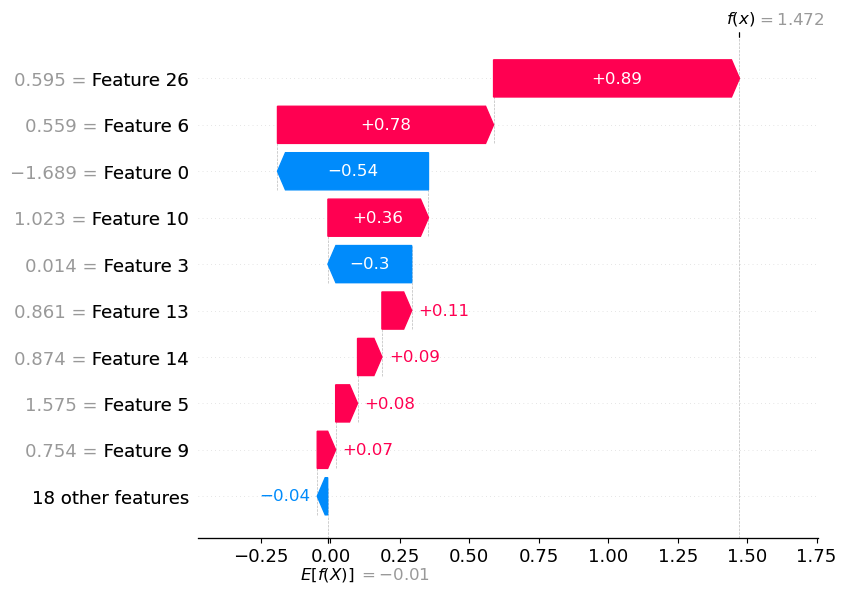

In [ ]:
import shap
import matplotlib.pyplot as plt

# Set plotting style for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

explainer = shap.Explainer(xgb_model, feature_names=available_features)
shap_values = explainer(dtest)
shap.plots.waterfall(shap_values[0])

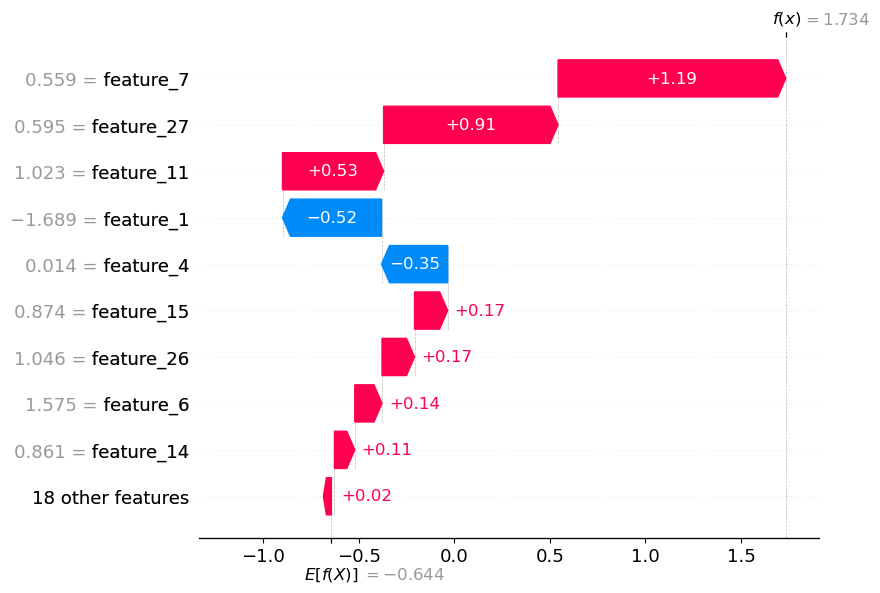

In [ ]:
explainer = shap.Explainer(lgb_model) 
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])